In [1]:
%load_ext autoreload

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import gpytorch

import torch
from PFNs.pfns.priors import Batch
from gpytorch.distributions.multivariate_normal import MultivariateNormal
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.kernel import Kernel
from gpytorch.means.constant_mean import ConstantMean
from gpytorch.priors.lkj_prior import LKJCovariancePrior
from linear_operator.operators import InterpolatedLinearOperator

import torch
from gen_batch import (
    combine_batch,
    get_hpo_batch_fn,
    get_icm,
    get_lmc,
    get_mtgp_batch,
)
from PFNs.pfns import (
    bar_distribution,
    encoders,
    priors,
    utils,
)
from PFNs.pfns.train import (
    train as train_pfn,
)
import sys
import logging
import os
import datetime
import json
import argparse


In [2]:
torch.cuda.is_available()

True

In [3]:
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

def train(
    get_batch_fn,
    num_features = 2,
    num_tasks = 1,
    seq_len = 20,
    epochs = 20,
    sample_num_features = False
):
    batch_fn_hypers = {
        "num_tasks": num_tasks,
        "sample_num_tasks": False,
        "sample_num_features": sample_num_features,
    }
    get_batch_fn = priors.get_batch_sequence(
        get_batch_fn,
        priors.utils.set_properties_get_batch,
    )
    criterion = torch.nn.GaussianNLLLoss(reduction="none", full=True)

    single_eval_pos_gen = utils.get_uniform_single_eval_pos_sampler(
        seq_len - num_tasks, min_len=num_tasks
    )
    
    encoder_generator = encoders.get_normalized_uniform_multitask_encoder(
        encoders.get_variable_num_features_multitask_encoder(encoders.Linear)
    )

    return train_pfn(
        priordataloader_class_or_get_batch = get_batch_fn,
        criterion = criterion,
        encoder_generator=encoder_generator,
        single_eval_pos_gen=single_eval_pos_gen,
        extra_prior_kwargs_dict = {
            "num_features": num_features,
            "hyperparameters": batch_fn_hypers,
        },
        num_features=num_features, 
        num_tasks=num_tasks, 
        seq_len=seq_len, 
        epochs=epochs,
        progress_bar=True,
        y_encoder_generator= encoders.Linear,
        steps_per_epoch = 256,
        print_every=1,
        validation_period=2,
    )

In [5]:

def sample_data(xs):
    # randomly sample uncorrelated tasks
    kernel = RBFKernel().to(xs.device)
    kernel.lengthscale = 0.2
    return MultivariateNormal(
                torch.zeros(xs.shape[:-1], device=xs.device), kernel(xs)
            ).sample()
    
    
def gen_batch(
    batch_size: int,
    seq_len: int,
    num_features: int,
    max_num_tasks: int,
    num_tasks: int,
    lengthscale: float,
    hyperparameters=None,
    device: str = default_device,
    **kwargs
):
    x1 = torch.rand(batch_size, seq_len, 1, device=device)
    x2 = torch.randn(batch_size, seq_len, 1, device=device)
    
    xs = torch.cat((x1, x2), -1)
    ys = sample_data(x1)
    ys += x2.squeeze(-1)
    task_ids = torch.ones(batch_size, seq_len, 1, device=device)
    task_xs = torch.cat((task_ids, xs), -1).to(device)

    return Batch(
        x=task_xs.transpose(0, 1),
        y=ys.transpose(0, 1),
        target_y=ys.transpose(0, 1).clone(),
    )

## Toy Problem

2 features: $x_1$ and $x_2$

$f \sim \mathcal{GP}(0, k_\text{RBF})$

$y = f(x_1) + x_2$

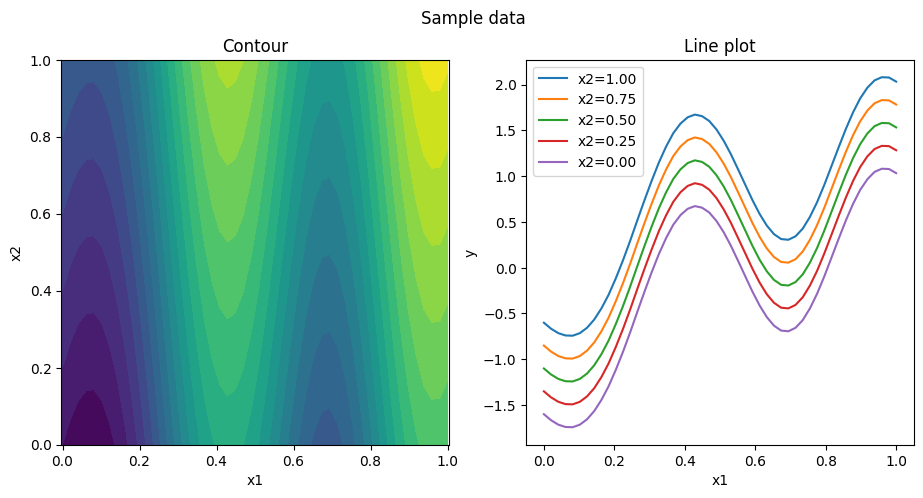

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle("Sample data")

x1 = torch.linspace(0, 1, 50).unsqueeze(-1)
x2 = torch.linspace(0, 1, 50).unsqueeze(-1)

f_x1 = sample_data(x1)
ys = f_x1.expand(50, 50) + x2.expand(50, 50)
axs[0].contourf(x1.squeeze(), x2.squeeze(), ys, levels=20)
axs[0].set_title("Contour")
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
axs[0].axis("equal")

for x2 in torch.linspace(1, 0, 5):
    ys = f_x1 + x2
    axs[1].plot(x1.squeeze(), ys.squeeze(), label="x2=%.2f" % x2)
axs[1].set_title("Line plot")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("y")
axs[1].legend()

plt.show()

#### Train single-task PFN on problem

In [63]:
total_loss, total_positional_losses, final_model, dl, best_val_score, best_model = train(get_batch_fn=gen_batch, num_features=2, num_tasks=1, seq_len=20, epochs=20)

/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Using cuda:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 256, 'get_batch_kwargs': {'batch_size': 200, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7ff916b3c9a0>, 'seq_len_maximum': 20, 'device': 'cuda:0', 'num_features': 2, 'hyperparameters': {'num_tasks': 1, 'sample_num_tasks': False, 'sample_num_features': False}}, 'num_features': 2, 'num_tasks': 1, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 2)  and nout 2
Using a Transformer with 1.49 M parameters
Using OpenAI max lr of 0.0012557515027448725.


Training Epoch:   0%|          | 0/256 [00:00<?, ?it/s]/home/yl9959/mtpfn/PFNs/pfns/train.py:286: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Eval Epoch:   0%|          | 0/512 [00:00<?, ?it/s]/home/yl9959/mtpfn/PFNs/pfns/train.py:525: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Eval Epoch:  50%|█████     | 256/512 [00:02<00:02, 97.66it/s, data_time=0.00359, step_time=0.00626, mean_loss=-1.65]


HERE


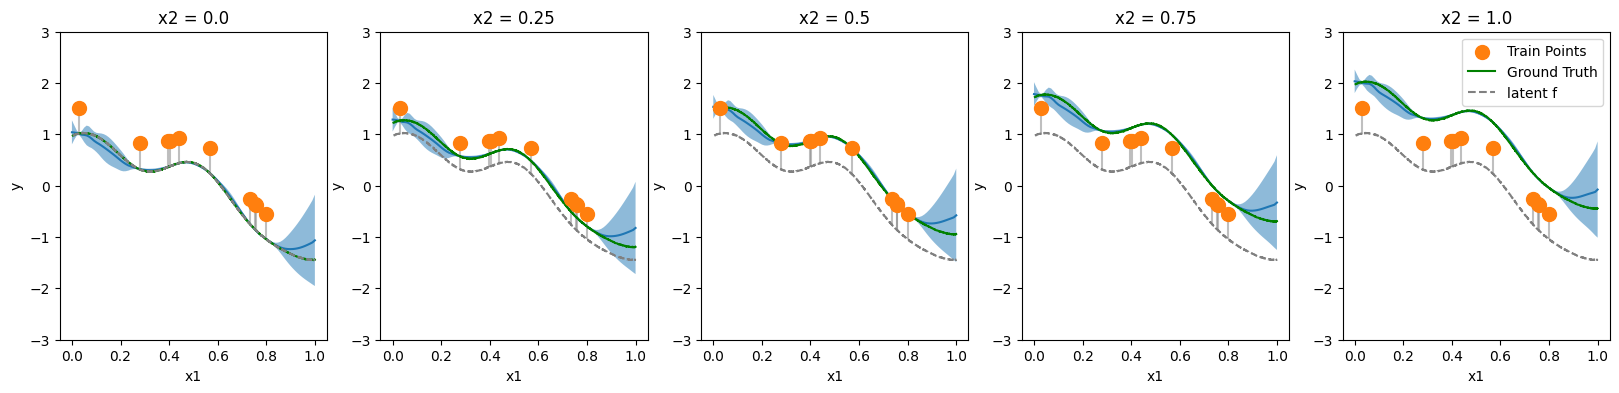

In [ ]:
torch.manual_seed(1)
train_x1 = torch.rand(1000)
TRAIN_CONST = 0.5
train_x2 = torch.ones_like(train_x1) * TRAIN_CONST
f = sample_data(train_x1.unsqueeze(-1))
train_y = f + train_x2
train_x = torch.cat((train_x1.unsqueeze(-1), train_x2.unsqueeze(-1)), -1)
task_train_x = torch.cat((torch.ones_like(train_x1).unsqueeze(-1), train_x), -1)

sorted_train_x1, indices = train_x1.sort()
sorted_f = f[indices]
sorted_train_x2 = train_x2[indices]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_x), -1)
    pfn_predictions = best_model(task_train_x[:10], train_y[:10], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10], color="grey", alpha=0.5)
    ax.scatter(train_x1[:10], train_y[:10], s=100, label="Train Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="latent f", linestyle="--")
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
plt.legend()
plt.show()

The model is able to fit this setup and make reasonable predictions for varied $x_1$ and constant $x_2$.

HERE


/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


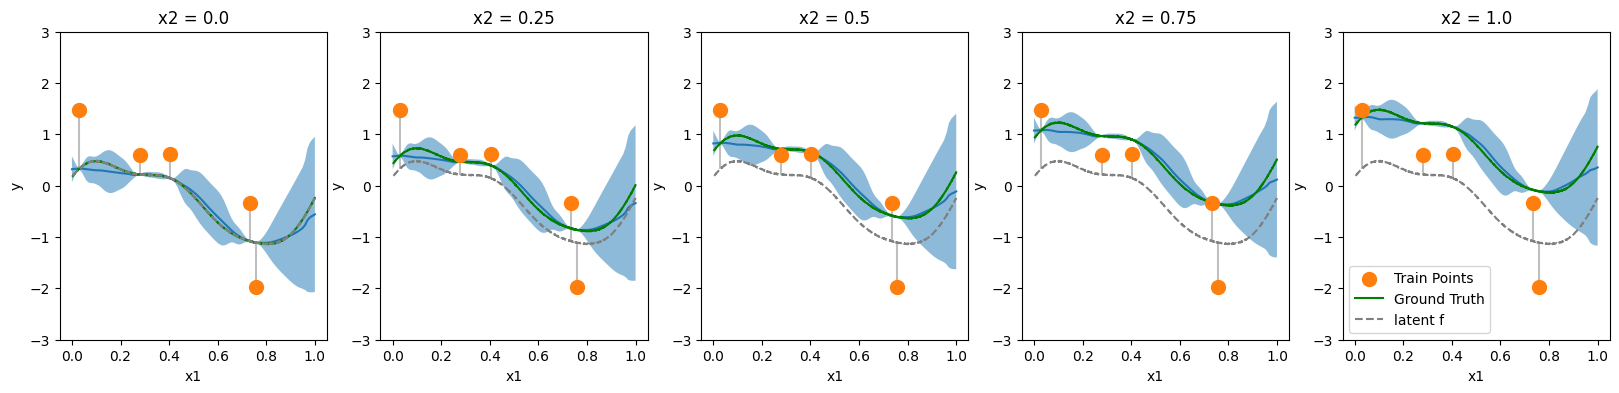

In [ ]:
torch.manual_seed(1)
N_POINTS = 5
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)
f = sample_data(train_x1.unsqueeze(-1))
train_y = f + train_x2
train_x = torch.cat((train_x1.unsqueeze(-1), train_x2.unsqueeze(-1)), -1)
task_train_x = torch.cat((torch.ones_like(train_x1).unsqueeze(-1), train_x), -1)

sorted_train_x1, indices = train_x1.sort()
sorted_f = f[indices]
sorted_train_x2 = train_x2[indices]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_x), -1)
    pfn_predictions = best_model(task_train_x[:N_POINTS], train_y[:N_POINTS], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:N_POINTS], f[:N_POINTS].squeeze(), f[:N_POINTS].squeeze() + train_x2[:N_POINTS], color="grey", alpha=0.5)
    ax.scatter(train_x1[:N_POINTS], train_y[:N_POINTS], s=100, label="Train Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="latent f", linestyle="--")
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
plt.legend()
plt.show()

The model is able to fit this setup and make reasonable predictions for varied $x_1$ and $x_2$.

## Missing Data

How does the model do when entire features ($x_1$ or $x_2$) are missing?

Each input is now the concatentation of
1. Task description: 2-bit vector indicating whether feature is present
2. Features: $\left[x_1\right]$, $\left[x_2\right]$ or $\left[x_1, x_2\right]$

The input is variable-length: could be 3 or 4 dimensional depending on number of missing columns.

In [7]:
def gen_missing_batch(
    batch_size: int,
    seq_len: int,
    num_features: int,
    max_num_tasks: int,
    num_tasks: int,
    lengthscale: float,
    hyperparameters=None,
    device: str = default_device,
    delete_x1=None,
    delete_x2=None,
    **kwargs
):
    x1 = torch.rand(batch_size, seq_len, 1, device=device)
    x2 = torch.randn(batch_size, seq_len, 1, device=device)
    
    ys = sample_data(x1)
    ys += x2.squeeze(-1)
    
    task_ids = torch.ones(batch_size, seq_len, 1, device=device)
    
    task_info = torch.ones(batch_size, seq_len, 2, device=device)
    if delete_x1 is None:
        delete_x1 = np.random.rand() < 0.2
    if delete_x2 is None:
        delete_x2 = np.random.rand() < 0.2 and not delete_x1
        
    # get accurate task embedding
    if delete_x1:
        task_info[:, :, 0] = 0
    if delete_x2:
        task_info[:, :, 1] = 0
        
    if delete_x1:
        xs = torch.cat((task_ids, task_info, x2), -1)
    elif delete_x2:
        xs = torch.cat((task_ids, task_info, x1), -1)
    else:
        xs = torch.cat((task_ids, task_info, x1, x2), -1)
    
    xs = xs.to(device)

    return Batch(
        x=xs.transpose(0, 1),
        y=ys.transpose(0, 1),
        target_y=ys.transpose(0, 1).clone(),
    )

In [8]:
total_loss, total_positional_losses, final_model, dl, best_val_score, best_model = train(get_batch_fn=gen_missing_batch, num_features=2, num_tasks=3, seq_len=20, epochs=20, sample_num_features=True)

Using cuda:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 256, 'get_batch_kwargs': {'batch_size': 200, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7efbdc328040>, 'seq_len_maximum': 20, 'device': 'cuda:0', 'num_features': 2, 'hyperparameters': {'num_tasks': 3, 'sample_num_tasks': False, 'sample_num_features': True}}, 'num_features': 2, 'num_tasks': 3, 'epoch_count': 0}


/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Style definition of first 3 examples: None
Initialized decoder for standard with (None, 2)  and nout 2
Using a Transformer with 1.49 M parameters
Using OpenAI max lr of 0.0012557141533970579.


Training Epoch:   0%|          | 0/256 [00:00<?, ?it/s]/home/yl9959/mtpfn/PFNs/pfns/train.py:286: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Eval Epoch:   0%|          | 0/512 [00:00<?, ?it/s]/home/yl9959/mtpfn/PFNs/pfns/train.py:525: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Eval Epoch:  50%|█████     | 256/512 [00:03<00:03, 81.54it/s, data_time=0.00349, step_time=0.00799, mean_loss=-0.482]


### Missing $x_1$

Only $x_2$ and $y$ are present in the training data, where the full model is $f \sim GP, y=f(x_1) + x_2$. This means that the model has no information about the shape.

/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


torch.Size([5, 4]) torch.Size([5]) torch.Size([100, 4])
torch.Size([5, 4]) torch.Size([5]) torch.Size([100, 4])
torch.Size([5, 4]) torch.Size([5]) torch.Size([100, 4])
torch.Size([5, 4]) torch.Size([5]) torch.Size([100, 4])
torch.Size([5, 4]) torch.Size([5]) torch.Size([100, 4])


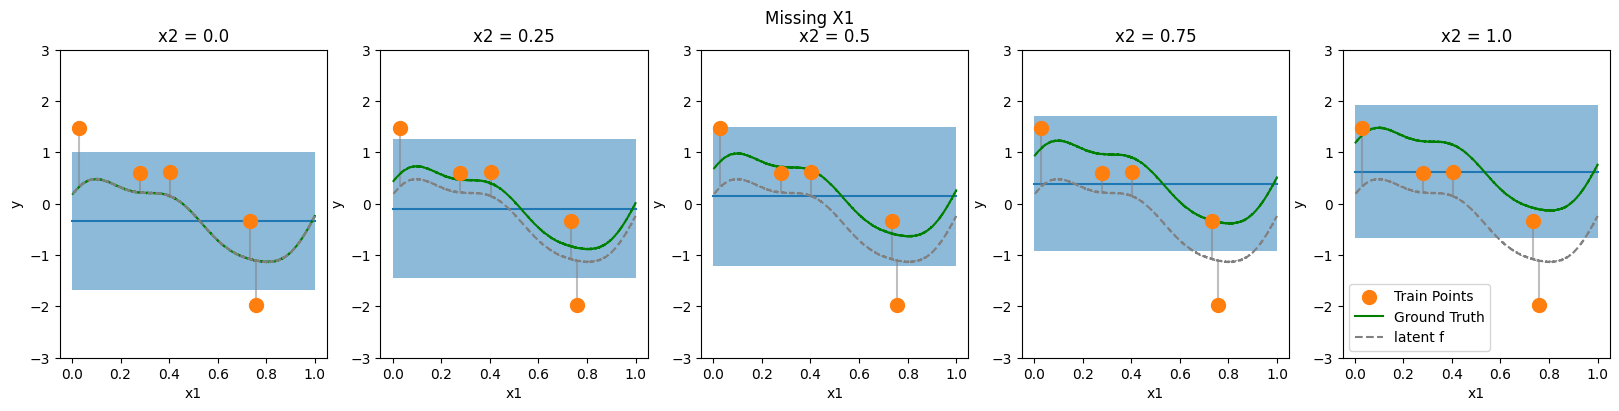

In [9]:
torch.manual_seed(1)
N_POINTS = 5
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)
f = sample_data(train_x1.unsqueeze(-1))
train_y = f + train_x2
train_x = torch.cat((train_x1.unsqueeze(-1), train_x2.unsqueeze(-1)), -1)

task_info = torch.ones(1000, 2)
task_info[:, 0] = 0

task_id = torch.ones(1000, 1)

task_train_x = torch.cat((task_id, task_info, train_x2.unsqueeze(-1)), -1)

sorted_train_x1, indices = train_x1.sort()
sorted_f = f[indices]
sorted_train_x2 = train_x2[indices]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_task_info = torch.ones(100, 2)
    test_task_info[:, 0] = 0
    test_task_id = torch.ones(100, 1)
    task_test_x = torch.cat((test_task_id, test_task_info, test_x2), -1)
    
    print(task_train_x[:N_POINTS].shape, train_y[:N_POINTS].shape, task_test_x.shape)
    pfn_predictions = best_model(task_train_x[:N_POINTS], train_y[:N_POINTS], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:N_POINTS], f[:N_POINTS].squeeze(), f[:N_POINTS].squeeze() + train_x2[:N_POINTS], color="grey", alpha=0.5)
    ax.scatter(train_x1[:N_POINTS], train_y[:N_POINTS], s=100, label="Train Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="latent f", linestyle="--")
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
plt.suptitle("Missing X1")
plt.legend()
plt.show()

### Missing $x_2$

Only $x_2$ and $y$ are present in the training data, where the full model is $f \sim GP, y=f(x_1) + x_2$. This means the model has shape information but doesn't know about the shift.

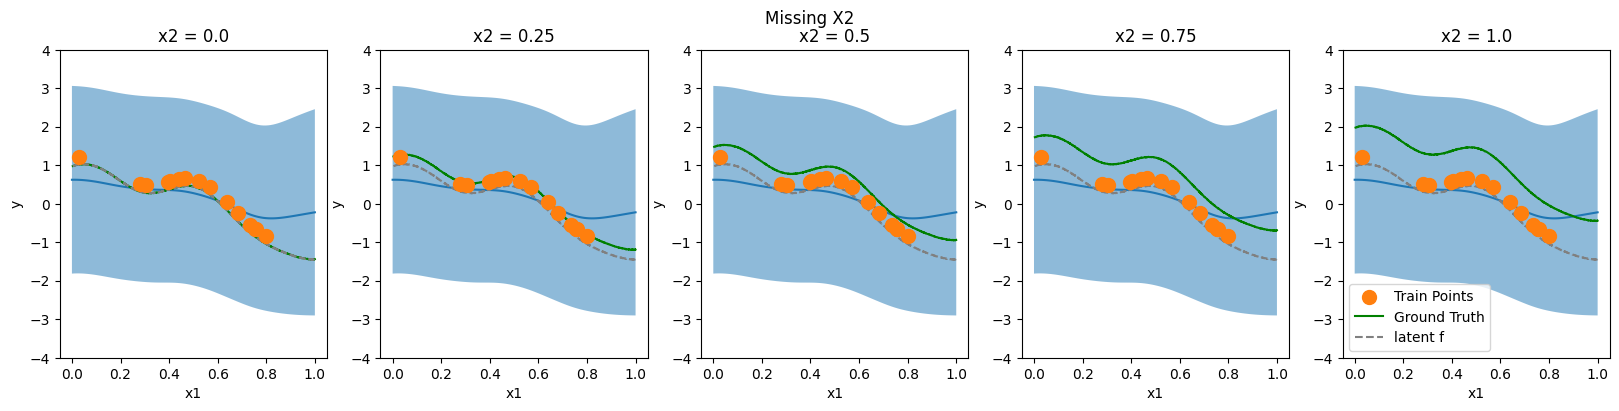

In [19]:
torch.manual_seed(1)
N_POINTS = 15
train_x1 = torch.rand(1000)
# train_x2 = torch.randn_like(train_x1)
train_x2 = torch.ones_like(train_x1) * 0.2
f = sample_data(train_x1.unsqueeze(-1))
train_y = f + train_x2
train_x = torch.cat((train_x1.unsqueeze(-1), train_x2.unsqueeze(-1)), -1)

task_info = torch.ones(1000, 2)
task_info[:, 1] = 0

task_id = torch.ones(1000, 1)

task_train_x = torch.cat((task_id, task_info, train_x1.unsqueeze(-1)), -1)

sorted_train_x1, indices = train_x1.sort()
sorted_f = f[indices]
sorted_train_x2 = train_x2[indices]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_task_info = torch.ones(100, 2)
    test_task_info[:, 1] = 0
    test_task_id = torch.ones(100, 1)
    task_test_x = torch.cat((test_task_id, test_task_info, test_x1), -1)
    
    pfn_predictions = best_model(task_train_x[:N_POINTS], train_y[:N_POINTS], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:N_POINTS], f[:N_POINTS].squeeze(), f[:N_POINTS].squeeze() + train_x2[:N_POINTS], color="grey", alpha=0.5)
    ax.scatter(train_x1[:N_POINTS], train_y[:N_POINTS], s=100, label="Train Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="latent f", linestyle="--")
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-4, 4)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
plt.suptitle("Missing X2")
plt.legend()
plt.show()

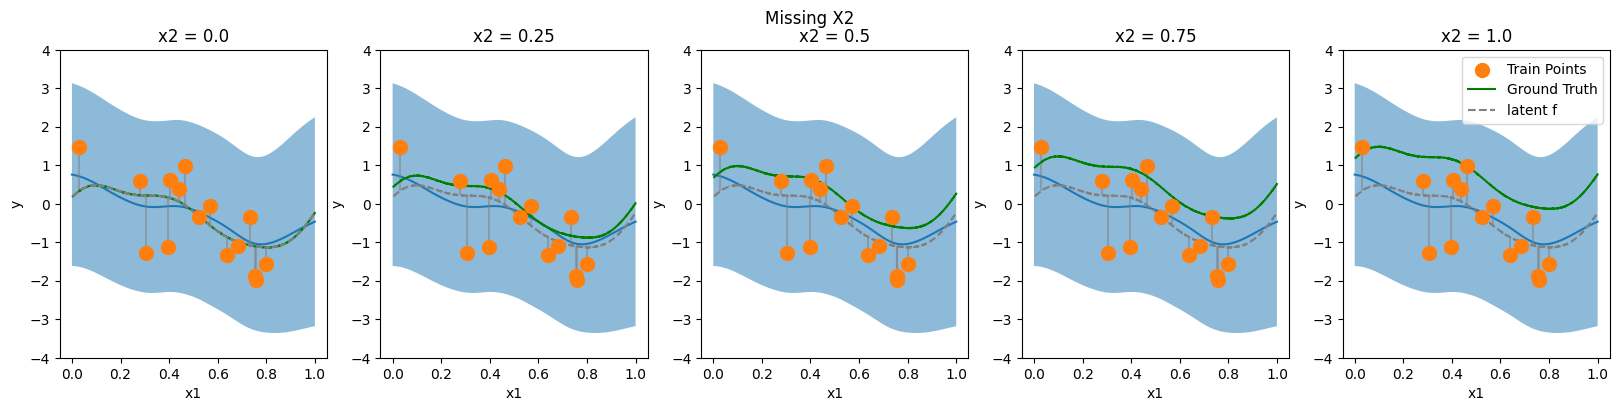

In [18]:
torch.manual_seed(1)
N_POINTS = 15
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)
f = sample_data(train_x1.unsqueeze(-1))
train_y = f + train_x2
train_x = torch.cat((train_x1.unsqueeze(-1), train_x2.unsqueeze(-1)), -1)

task_info = torch.ones(1000, 2)
task_info[:, 1] = 0

task_id = torch.ones(1000, 1)

task_train_x = torch.cat((task_id, task_info, train_x1.unsqueeze(-1)), -1)

sorted_train_x1, indices = train_x1.sort()
sorted_f = f[indices]
sorted_train_x2 = train_x2[indices]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_task_info = torch.ones(100, 2)
    test_task_info[:, 1] = 0
    test_task_id = torch.ones(100, 1)
    task_test_x = torch.cat((test_task_id, test_task_info, test_x1), -1)
    
    pfn_predictions = best_model(task_train_x[:N_POINTS], train_y[:N_POINTS], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:N_POINTS], f[:N_POINTS].squeeze(), f[:N_POINTS].squeeze() + train_x2[:N_POINTS], color="grey", alpha=0.5)
    ax.scatter(train_x1[:N_POINTS], train_y[:N_POINTS], s=100, label="Train Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="latent f", linestyle="--")
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-4, 4)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
plt.suptitle("Missing X2")
plt.legend()
plt.show()

## Transfer Learning

Shared:
$f \sim \mathcal{GP}(0, k_\text{RBF}), c \sim \text{Uniform}(0, 10)$

Source: $y = -f(x_1) + cx_2$

Target: $y = f(x_1) + cx_2$




In [38]:
def gen_transfer_batch(
    batch_size: int,
    seq_len: int,
    num_features: int,
    max_num_tasks: int,
    num_tasks: int,
    lengthscale: float,
    hyperparameters=None,
    device: str = default_device,
    **kwargs
):
    x1 = torch.rand(batch_size, seq_len, 1, device=device)
    x2 = torch.randn(batch_size, seq_len, 1, device=device)
    c = torch.rand(batch_size, device=device) * 10
    task_ids = torch.randint(0, 2, (batch_size, seq_len), device=device).float()
    task_id[:2] = torch.tensor([0, 1], device=device).unsqueeze(-1)
    task_ids[-2:] = torch.tensor([0, 1], device=device).unsqueeze(-1)
    
    f = sample_data(x1)
    source_ys = f + x2.squeeze(-1) * c.unsqueeze(-1)
    target_ys = -f + x2.squeeze(-1) * c.unsqueeze(-1)
    
    task_xs = torch.cat((task_ids.unsqueeze(-1), x1, x2), -1).to(device)
    ys = torch.where(task_ids == 0, source_ys, target_ys)

    return Batch(
        x=task_xs.transpose(0, 1),
        y=ys.transpose(0, 1),
        target_y=ys.transpose(0, 1).clone(),
    )

#### Train without missing data

In [40]:
total_loss, total_positional_losses, final_model, dl, best_val_score, best_model = train(get_batch_fn=gen_transfer_batch, num_features=2, num_tasks=1, seq_len=30, epochs=20, sample_num_features=False)

Using cuda:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 256, 'get_batch_kwargs': {'batch_size': 200, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7efb5cfe9bc0>, 'seq_len_maximum': 30, 'device': 'cuda:0', 'num_features': 2, 'hyperparameters': {'num_tasks': 1, 'sample_num_tasks': False, 'sample_num_features': False}}, 'num_features': 2, 'num_tasks': 1, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 2)  and nout 2
Using a Transformer with 1.49 M parameters
Using OpenAI max lr of 0.0012557515027448725.


Training Epoch:   0%|          | 0/256 [00:00<?, ?it/s]

Eval Epoch:   0%|          | 0/512 [00:00<?, ?it/s]/home/yl9959/mtpfn/PFNs/pfns/train.py:525: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Eval Epoch:  50%|█████     | 256/512 [00:07<00:07, 35.97it/s, data_time=0.00294, step_time=0.00872, mean_loss=-0.643]


Without transfer learning, there is a large amount of uncertainty

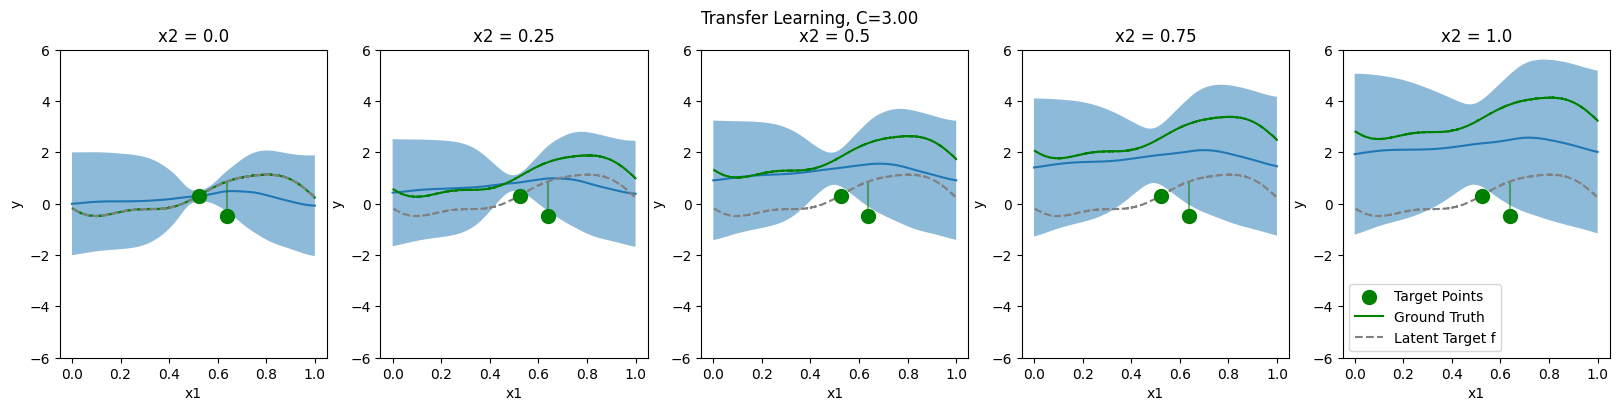

In [127]:

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_x), -1)
    pfn_predictions = best_model(task_train_x[10:12], train_y[10:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    # ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    # ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10, color="green")
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-6, 6)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning, C=%.2f" % c)
plt.legend()
plt.show()

The transfer learning really helps the model learn the shape ($f$) as well as the amount of shift ($c$)

/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


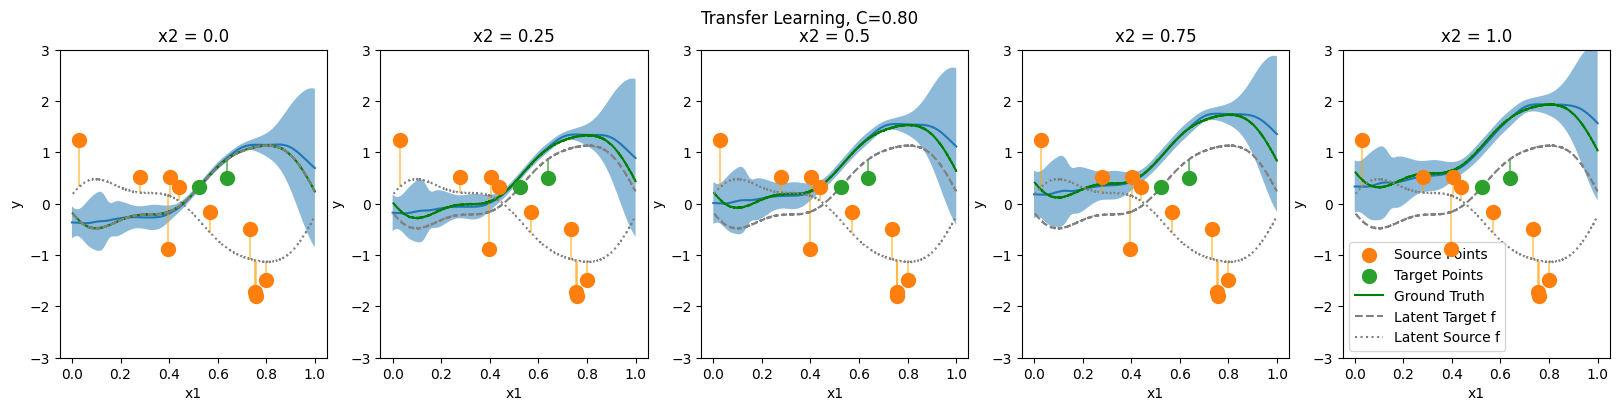

In [114]:
torch.manual_seed(1)
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)

f = sample_data(train_x1.unsqueeze(-1))
c = 0.8 #(torch.rand(1) * 10).item()
task_ids = torch.randint(0, 2, (1000,)).float().squeeze()
task_ids[:10] = 0 # source task
task_ids[10:12] = 1 # target task

source_ys = f + train_x2 * c
target_ys = -f + train_x2 * c

task_train_x = torch.stack((task_ids, train_x1, train_x2), -1)
train_y = torch.where(task_ids == 0, source_ys, target_ys)

sorted_train_x1, indices = train_x1.squeeze().sort()
sorted_f = -f[indices.squeeze()]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_x), -1)
    pfn_predictions = best_model(task_train_x[:12], train_y[:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    ax.plot(sorted_train_x1, -sorted_f, color="grey", label="Latent Source f", linestyle="dotted")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning, C=%.2f" % c)
plt.legend()
plt.show()

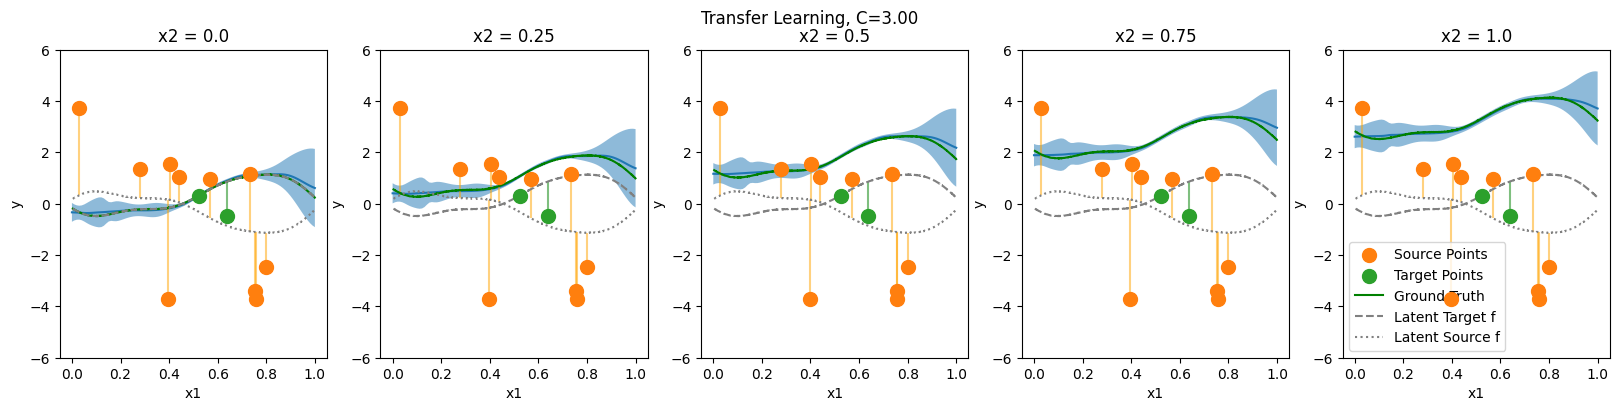

In [122]:
torch.manual_seed(1)
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)

f = sample_data(train_x1.unsqueeze(-1))
c = 3.0 #(torch.rand(1) * 10).item()
task_ids = torch.randint(0, 2, (1000,)).float().squeeze()
task_ids[:10] = 0 # source task
task_ids[10:12] = 1 # target task

source_ys = f + train_x2 * c
target_ys = -f + train_x2 * c

task_train_x = torch.stack((task_ids, train_x1, train_x2), -1)
train_y = torch.where(task_ids == 0, source_ys, target_ys)

sorted_train_x1, indices = train_x1.squeeze().sort()
sorted_f = -f[indices.squeeze()]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_x), -1)
    pfn_predictions = best_model(task_train_x[:12], train_y[:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    ax.plot(sorted_train_x1, -sorted_f, color="grey", label="Latent Source f", linestyle="dotted")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-6, 6)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning, C=%.2f" % c)
plt.legend()
plt.show()

### Transfer Learning with Missing Data

In [ ]:
def gen_transfer_missing_batch(
    batch_size: int,
    seq_len: int,
    num_features: int,
    max_num_tasks: int,
    num_tasks: int,
    lengthscale: float,
    hyperparameters=None,
    device: str = default_device,
    **kwargs
):
    x1 = torch.rand(batch_size, seq_len, 1, device=device)
    x2 = torch.randn(batch_size, seq_len, 1, device=device)
    c = torch.rand(batch_size, device=device) * 10
    task_ids = torch.randint(0, 2, (batch_size, seq_len), device=device).float()
    task_ids[..., :2] = torch.tensor([0, 1], device=device)
    task_ids[..., -2:] = torch.tensor([0, 1], device=device)
    
    f = sample_data(x1)
    source_ys = f + x2.squeeze(-1) * c.unsqueeze(-1)
    target_ys = -f + x2.squeeze(-1) * c.unsqueeze(-1)
    
    xs = torch.zeros(batch_size, seq_len, 5).to(device).reshape(-1, 5)
    task_id_flat = task_ids.flatten()
    xs[:, 0] = task_id_flat
    for task_id in range(2):
        delete_x1 = np.random.rand() < 0.2
        delete_x2 = np.random.rand() < 0.2 and not delete_x1
        
        relevant_task_ids = task_id_flat == task_id
        xs[relevant_task_ids, 1:3] = 1
        if delete_x1:
            xs[relevant_task_ids, 1] = 0
            xs[relevant_task_ids, 3] = x2.flatten()[relevant_task_ids]
        elif delete_x2:
            xs[relevant_task_ids, 2] = 0
            xs[relevant_task_ids, 3] = x1.flatten()[relevant_task_ids]
        else:
            xs[relevant_task_ids, 3] = x1.flatten()[relevant_task_ids]
            xs[relevant_task_ids, 4] = x2.flatten()[relevant_task_ids]
    
    xs = xs.reshape(batch_size, seq_len, 5)
    ys = torch.where(task_ids == 0, source_ys, target_ys)

    return Batch(
        x=xs.transpose(0, 1),
        y=ys.transpose(0, 1),
        target_y=ys.transpose(0, 1).clone(),
    )
# gen_transfer_missing_batch(4, 5, 2, 1, 1, 0.1).x.transpose(0, 1)

tensor([[[ 0.0000,  0.0000,  1.0000, -1.4068,  0.0000],
         [ 1.0000,  1.0000,  1.0000,  0.4449,  1.3667],
         [ 1.0000,  1.0000,  1.0000,  0.0879,  0.3745],
         [ 0.0000,  0.0000,  1.0000, -0.8154,  0.0000],
         [ 1.0000,  1.0000,  1.0000,  0.5876,  0.6553]],

        [[ 0.0000,  0.0000,  1.0000, -1.0935,  0.0000],
         [ 1.0000,  1.0000,  1.0000,  0.5568, -0.5042],
         [ 0.0000,  0.0000,  1.0000,  1.8983,  0.0000],
         [ 0.0000,  0.0000,  1.0000, -1.8532,  0.0000],
         [ 1.0000,  1.0000,  1.0000,  0.0297, -0.4621]],

        [[ 0.0000,  0.0000,  1.0000,  0.5832,  0.0000],
         [ 1.0000,  1.0000,  1.0000,  0.0319, -0.5039],
         [ 1.0000,  1.0000,  1.0000,  0.7601,  0.0962],
         [ 0.0000,  0.0000,  1.0000,  0.5355,  0.0000],
         [ 1.0000,  1.0000,  1.0000,  0.6945,  0.8844]],

        [[ 0.0000,  0.0000,  1.0000, -0.6043,  0.0000],
         [ 1.0000,  1.0000,  1.0000,  0.1699, -0.9647],
         [ 1.0000,  1.0000,  1.0000,  0.22

In [106]:
total_loss, total_positional_losses, final_model, dl, best_val_score, best_model = train(get_batch_fn=gen_transfer_missing_batch, num_features=2, num_tasks=3, seq_len=30, epochs=50, sample_num_features=False)

/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Using cuda:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 256, 'get_batch_kwargs': {'batch_size': 200, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7f70301ef240>, 'seq_len_maximum': 30, 'device': 'cuda:0', 'num_features': 2, 'hyperparameters': {'num_tasks': 3, 'sample_num_tasks': False, 'sample_num_features': False}}, 'num_features': 2, 'num_tasks': 3, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 2)  and nout 2
Using a Transformer with 1.49 M parameters
Using OpenAI max lr of 0.0012557141533970579.


Training Epoch:   0%|          | 0/256 [00:00<?, ?it/s]/home/yl9959/mtpfn/PFNs/pfns/train.py:286: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Eval Epoch:   0%|          | 0/512 [00:00<?, ?it/s]/home/yl9959/mtpfn/PFNs/pfns/train.py:525: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Eval Epoch:  45%|████▌     | 232/512 [00:02<00:03, 78.91it/s, data_time=0.00343, step_time=0.0084, mean_loss=2.13] /ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
Eval Epoch:  50%|█████     | 256/512 [00:03<00:03, 77.01it/s, data_time=0.00345, step_time=0.00761, mean_loss=0.307]   


/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


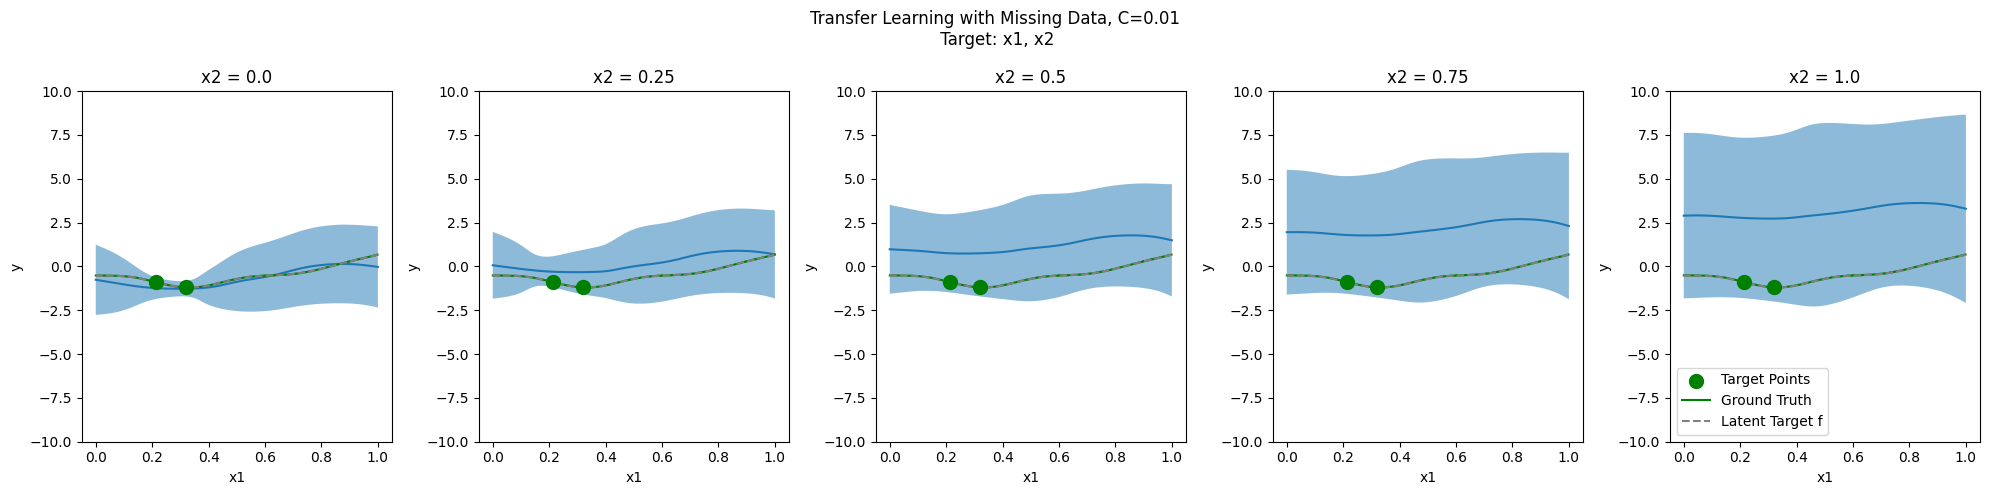

In [138]:
torch.manual_seed(4)
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)
train_x2[10] = 0.2 / 8
train_x2[11] = 0.8 / 8

f = sample_data(train_x1.unsqueeze(-1))
c = 0.01 #(torch.rand(1) * 10).item()
task_ids = torch.randint(0, 2, (1000,)).float().squeeze()
task_ids[:10] = 0 # source task
task_ids[10:12] = 1 # target task

source_ys = f + train_x2 * c
target_ys = -f + train_x2 * c

task_info = torch.ones(1000, 2)
source_tasks = task_ids == 0
task_info[source_tasks, 0] = 0

all_features = torch.stack((train_x1, train_x2), -1)
source_features = all_features[source_tasks]
all_features[source_tasks] = torch.cat((source_features[..., 1:], torch.zeros_like(source_features[..., 1:])), -1)

task_train_x = torch.cat((task_ids.unsqueeze(-1), task_info, all_features), -1)
train_y = torch.where(task_ids == 0, source_ys, target_ys)

sorted_train_x1, indices = train_x1.squeeze().sort()
sorted_f = -f[indices.squeeze()]

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    test_info = torch.ones(100, 2)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_info, test_x), -1)
    pfn_predictions = best_model(task_train_x[10:12], train_y[10:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    # ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    # ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10, color="green")
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    # ax.plot(sorted_train_x1, -sorted_f, color="grey", label="Latent Source f", linestyle="dotted")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-10, 10)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning with Missing Data, C=%.2f\n Target: x1, x2" % c)
plt.legend()
plt.tight_layout()
plt.show()

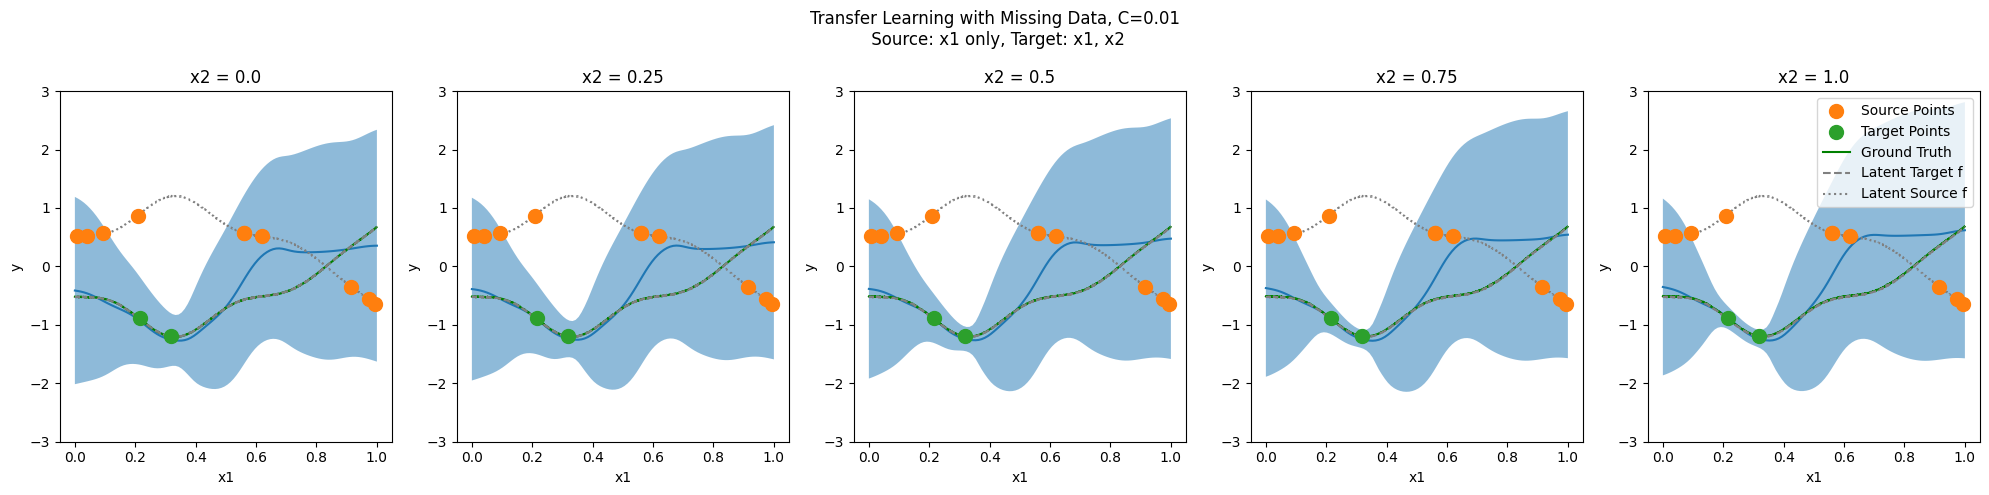

In [123]:
torch.manual_seed(4)
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)

f = sample_data(train_x1.unsqueeze(-1))
c = 0.01 #(torch.rand(1) * 10).item()
task_ids = torch.randint(0, 2, (1000,)).float().squeeze()
task_ids[:10] = 0 # source task
task_ids[10:12] = 1 # target task

source_ys = f + train_x2 * c
target_ys = -f + train_x2 * c

task_info = torch.ones(1000, 2)
source_tasks = task_ids == 0
task_info[source_tasks, 0] = 0

all_features = torch.stack((train_x1, train_x2), -1)
source_features = all_features[source_tasks]
all_features[source_tasks] = torch.cat((source_features[..., :1], torch.zeros_like(source_features[..., 1:])), -1)

task_train_x = torch.cat((task_ids.unsqueeze(-1), task_info, all_features), -1)
train_y = torch.where(task_ids == 0, source_ys, target_ys)

sorted_train_x1, indices = train_x1.squeeze().sort()
sorted_f = -f[indices.squeeze()]

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    test_info = torch.ones(100, 2)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_info, test_x), -1)
    pfn_predictions = best_model(task_train_x[:12], train_y[:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    ax.plot(sorted_train_x1, -sorted_f, color="grey", label="Latent Source f", linestyle="dotted")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning with Missing Data, C=%.2f\n Source: x1 only, Target: x1, x2" % c)
plt.legend()
plt.tight_layout()
plt.legend()
plt.show()

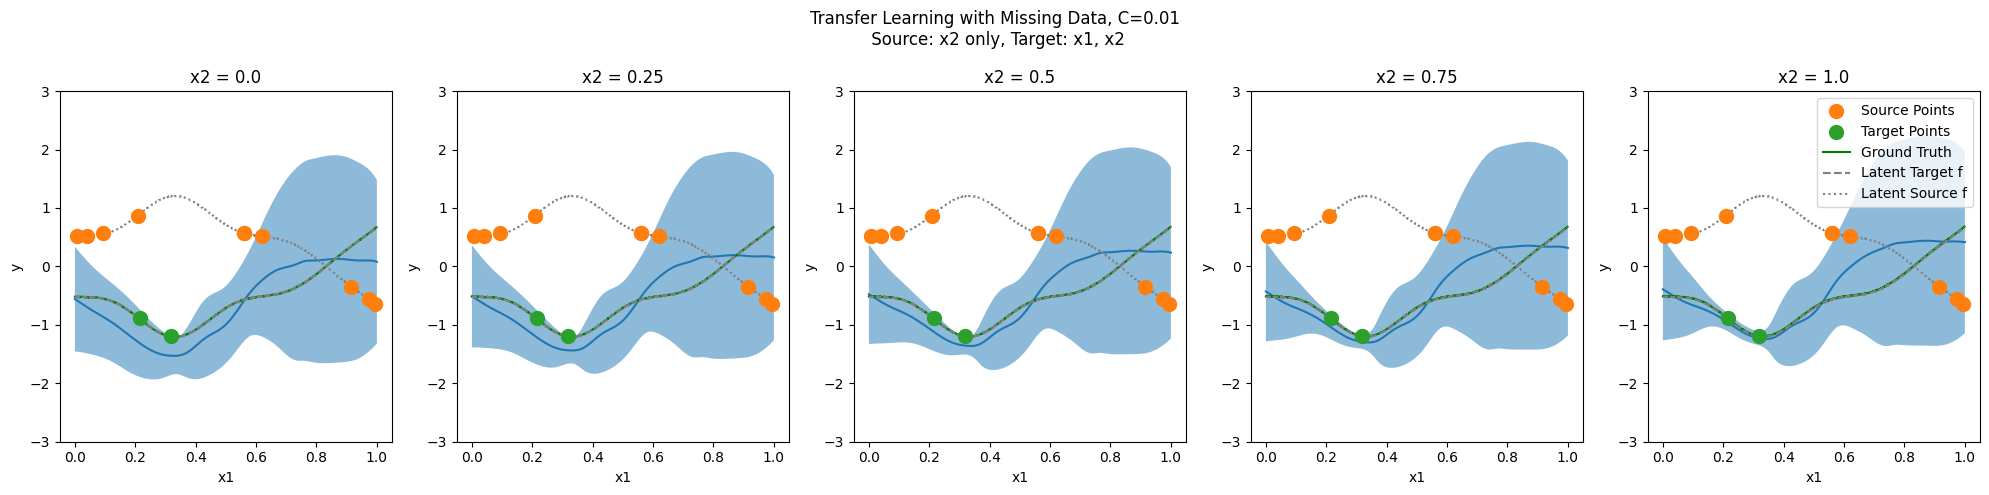

In [124]:
torch.manual_seed(4)
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)

f = sample_data(train_x1.unsqueeze(-1))
c = 0.01 #(torch.rand(1) * 10).item()
task_ids = torch.randint(0, 2, (1000,)).float().squeeze()
task_ids[:10] = 0 # source task
task_ids[10:12] = 1 # target task

source_ys = f + train_x2 * c
target_ys = -f + train_x2 * c

task_info = torch.ones(1000, 2)
source_tasks = task_ids == 0
task_info[source_tasks, 1] = 0

all_features = torch.stack((train_x1, train_x2), -1)
source_features = all_features[source_tasks]
all_features[source_tasks] = torch.cat((source_features[..., 1:], torch.zeros_like(source_features[..., 1:])), -1)

task_train_x = torch.cat((task_ids.unsqueeze(-1), task_info, all_features), -1)
train_y = torch.where(task_ids == 0, source_ys, target_ys)

sorted_train_x1, indices = train_x1.squeeze().sort()
sorted_f = -f[indices.squeeze()]

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    test_info = torch.ones(100, 2)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_info, test_x), -1)
    pfn_predictions = best_model(task_train_x[:12], train_y[:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    ax.plot(sorted_train_x1, -sorted_f, color="grey", label="Latent Source f", linestyle="dotted")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning with Missing Data, C=%.2f\n Source: x2 only, Target: x1, x2" % c)
plt.legend()
plt.tight_layout()
plt.legend()
plt.show()

/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/ext3/miniconda3/envs/pfn/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


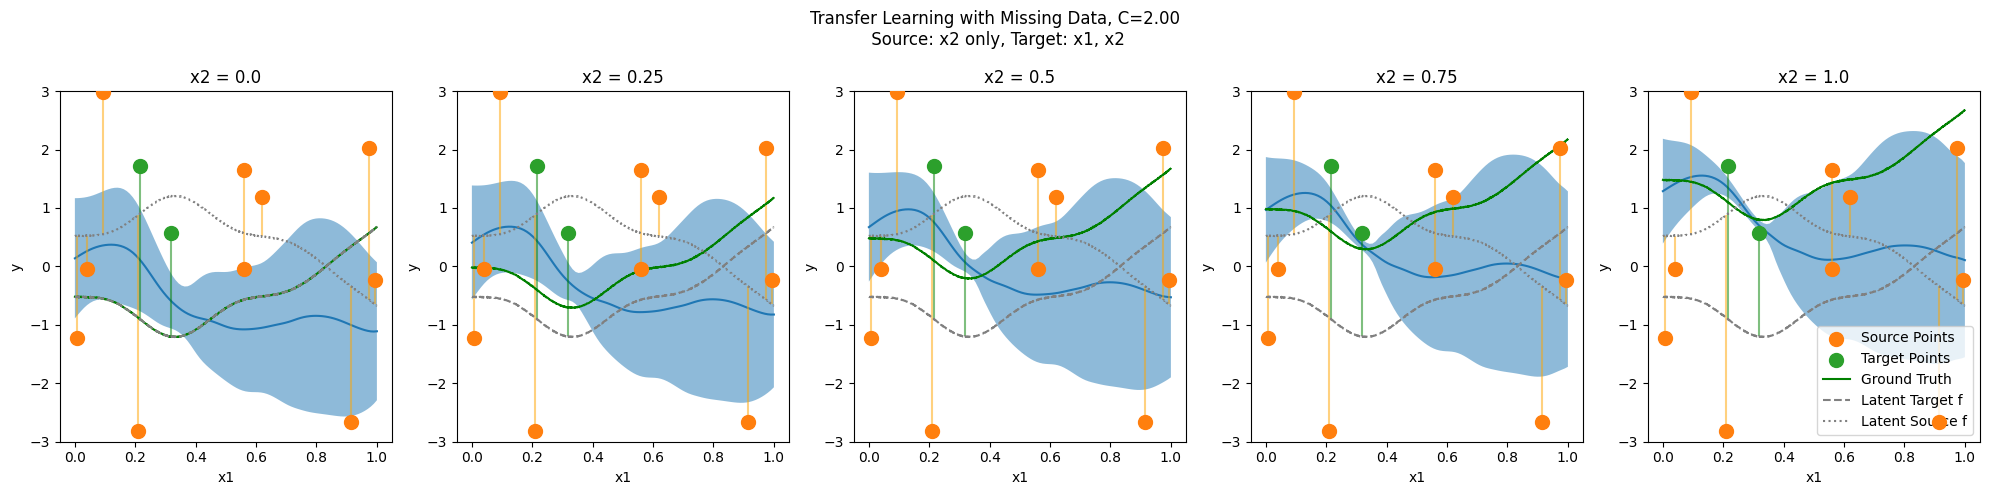

In [125]:
torch.manual_seed(4)
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)

f = sample_data(train_x1.unsqueeze(-1))
c = 2.0 #(torch.rand(1) * 10).item()
task_ids = torch.randint(0, 2, (1000,)).float().squeeze()
task_ids[:10] = 0 # source task
task_ids[10:12] = 1 # target task

source_ys = f + train_x2 * c
target_ys = -f + train_x2 * c

task_info = torch.ones(1000, 2)
source_tasks = task_ids == 0
task_info[source_tasks, 1] = 0

all_features = torch.stack((train_x1, train_x2), -1)
source_features = all_features[source_tasks]
all_features[source_tasks] = torch.cat((source_features[..., 1:], torch.zeros_like(source_features[..., 1:])), -1)

task_train_x = torch.cat((task_ids.unsqueeze(-1), task_info, all_features), -1)
train_y = torch.where(task_ids == 0, source_ys, target_ys)

sorted_train_x1, indices = train_x1.squeeze().sort()
sorted_f = -f[indices.squeeze()]

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, test_x2), -1)
    test_info = torch.ones(100, 2)
    task_test_x = torch.cat((torch.ones_like(test_x1), test_info, test_x), -1)
    pfn_predictions = best_model(task_train_x[:12], train_y[:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    ax.plot(sorted_train_x1, -sorted_f, color="grey", label="Latent Source f", linestyle="dotted")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning with Missing Data, C=%.2f\n Source: x2 only, Target: x1, x2" % c)
plt.legend()
plt.tight_layout()
plt.legend()
plt.show()

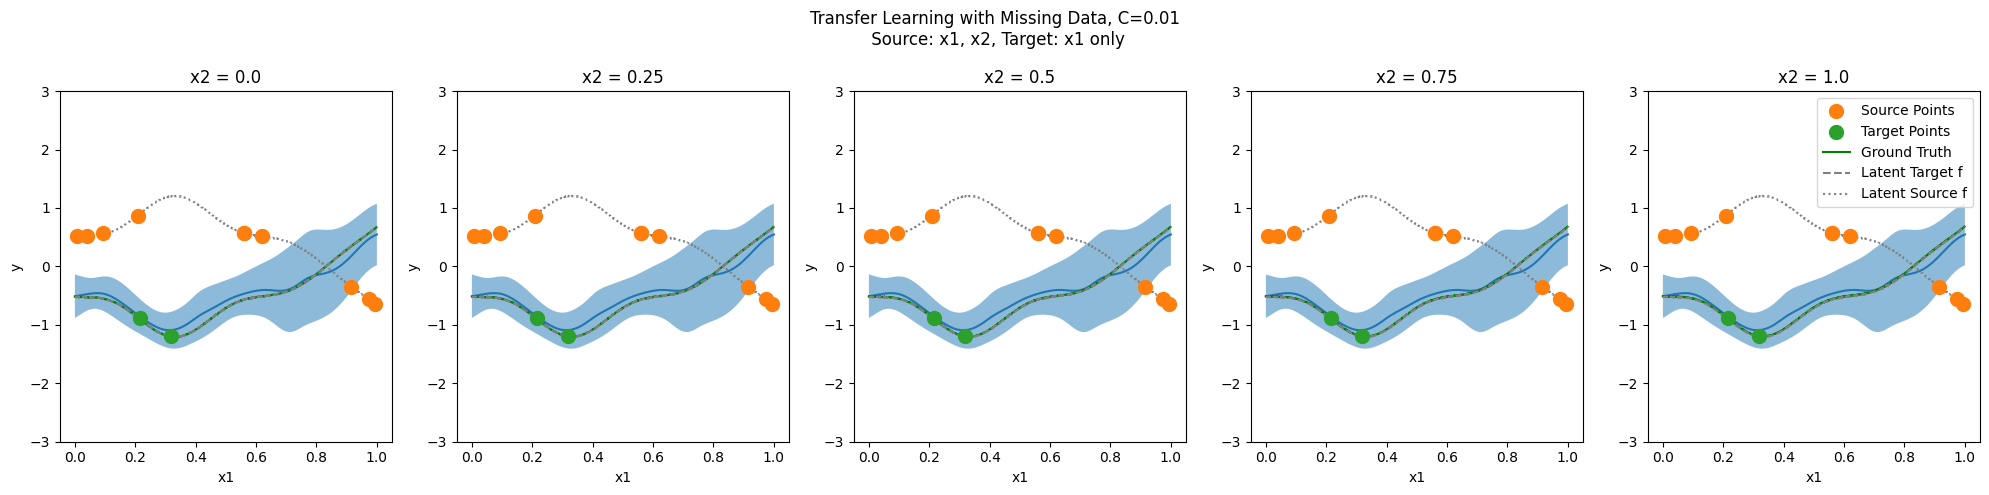

In [131]:
torch.manual_seed(4)
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)

f = sample_data(train_x1.unsqueeze(-1))
c = 0.01 #(torch.rand(1) * 10).item()
task_ids = torch.randint(0, 2, (1000,)).float().squeeze()
task_ids[:10] = 0 # source task
task_ids[10:12] = 1 # target task

source_ys = f + train_x2 * c
target_ys = -f + train_x2 * c

task_info = torch.ones(1000, 2)
target_tasks = task_ids == 1
task_info[target_tasks, 1] = 0

all_features = torch.stack((train_x1, train_x2), -1)
target_features = all_features[target_tasks]
all_features[target_tasks] = torch.cat((target_features[..., :1], torch.zeros_like(target_features[..., 1:])), -1)

task_train_x = torch.cat((task_ids.unsqueeze(-1), task_info, all_features), -1)
train_y = torch.where(task_ids == 0, source_ys, target_ys)

sorted_train_x1, indices = train_x1.squeeze().sort()
sorted_f = -f[indices.squeeze()]

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x1, torch.zeros_like(test_x1)), -1)
    test_info = torch.ones(100, 2)
    test_info[:, 1] = 0
    task_test_x = torch.cat((torch.ones_like(test_x1), test_info, test_x), -1)
    pfn_predictions = best_model(task_train_x[:12], train_y[:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    ax.plot(sorted_train_x1, -sorted_f, color="grey", label="Latent Source f", linestyle="dotted")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning with Missing Data, C=%.2f\n Source: x1, x2, Target: x1 only" % c)
plt.legend()
plt.tight_layout()
plt.show()

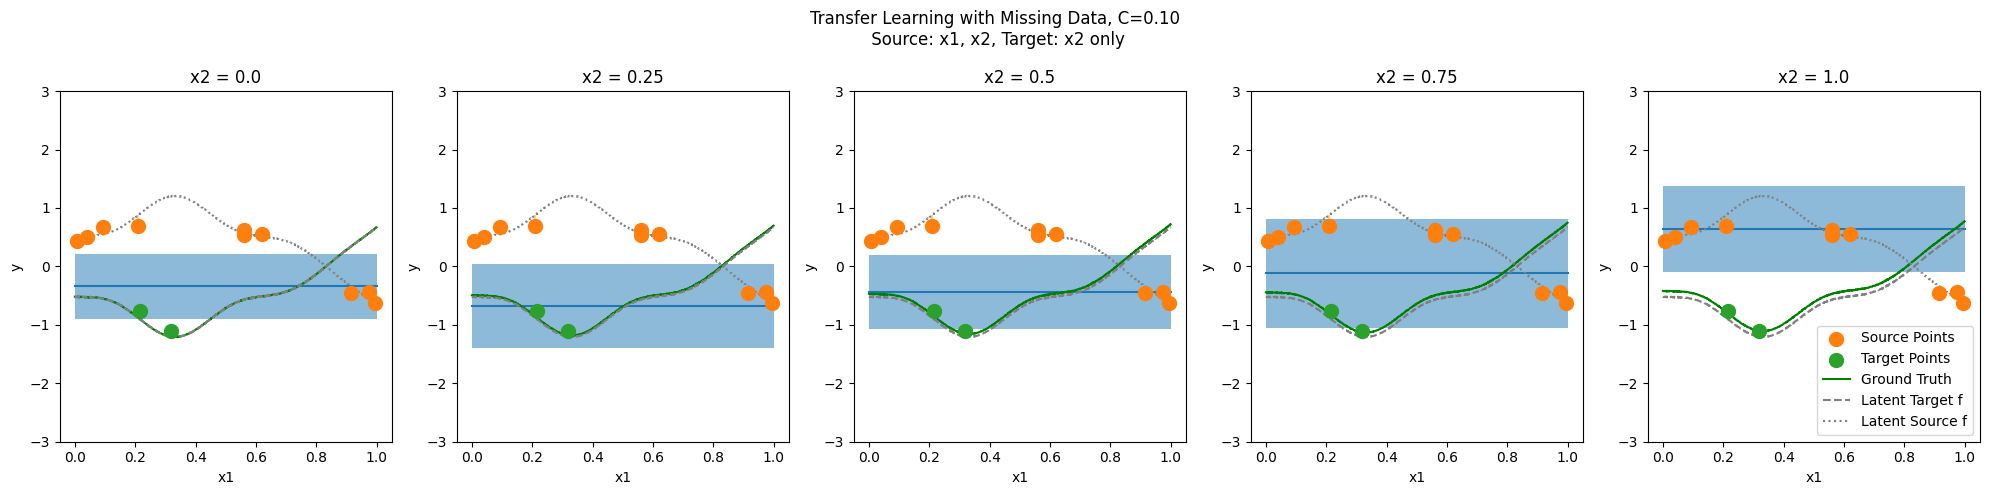

In [130]:
torch.manual_seed(4)
train_x1 = torch.rand(1000)
train_x2 = torch.randn_like(train_x1)

f = sample_data(train_x1.unsqueeze(-1))
c = 0.1 #(torch.rand(1) * 10).item()
task_ids = torch.randint(0, 2, (1000,)).float().squeeze()
task_ids[:10] = 0 # source task
task_ids[10:12] = 1 # target task

source_ys = f + train_x2 * c
target_ys = -f + train_x2 * c

task_info = torch.ones(1000, 2)
target_tasks = task_ids == 1
task_info[target_tasks, 0] = 0

all_features = torch.stack((train_x1, train_x2), -1)
target_features = all_features[target_tasks]
all_features[target_tasks] = torch.cat((target_features[..., :1], torch.zeros_like(target_features[..., 1:])), -1)

task_train_x = torch.cat((task_ids.unsqueeze(-1), task_info, all_features), -1)
train_y = torch.where(task_ids == 0, source_ys, target_ys)

sorted_train_x1, indices = train_x1.squeeze().sort()
sorted_f = -f[indices.squeeze()]

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for ax, x2 in zip(axs, torch.linspace(0, 1, 5)):
    test_x1 = torch.linspace(0, 1, 100).unsqueeze(-1)
    test_x2 = torch.ones_like(test_x1) * x2
    test_x = torch.cat((test_x2, torch.zeros_like(test_x2)), -1)
    test_info = torch.ones(100, 2)
    test_info[:, 1] = 0
    task_test_x = torch.cat((torch.ones_like(test_x1), test_info, test_x), -1)
    pfn_predictions = best_model(task_train_x[:12], train_y[:12], task_test_x)

    mean_preds = pfn_predictions[:, 0].detach().squeeze()
    std2_preds = pfn_predictions[:, 1].exp().detach().sqrt().squeeze() * 2

    ax.plot(test_x1, mean_preds)
    ax.fill_between(
        test_x1.squeeze(),
        mean_preds - std2_preds,
        mean_preds + std2_preds,
        alpha=0.5,
    )
    # vertical lines per point
    ax.vlines(train_x1[:10], f[:10].squeeze(), f[:10].squeeze() + train_x2[:10] * c, color="orange", alpha=0.5)
    ax.vlines(train_x1[10:12], -f[10:12].squeeze(), -f[10:12].squeeze() + train_x2[10:12] * c, color="green", alpha=0.5)
    
    
    ax.scatter(train_x1[:10], train_y[:10], s=100, label="Source Points", zorder=10)
    ax.scatter(train_x1[10:12], train_y[10:12], s=100, label="Target Points", zorder=10)
    
    
    ax.plot(sorted_train_x1, sorted_f + x2 * c, color="green", label="Ground Truth")
    ax.plot(sorted_train_x1, sorted_f, color="grey", label="Latent Target f", linestyle="--")
    ax.plot(sorted_train_x1, -sorted_f, color="grey", label="Latent Source f", linestyle="dotted")
    
    ax.set_title(f"x2 = {x2}")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x1")
    ax.set_ylabel("y")
    
plt.suptitle("Transfer Learning with Missing Data, C=%.2f\n Source: x1, x2, Target: x2 only" % c)
plt.legend()
plt.tight_layout()
plt.legend()
plt.show()